### TODO
- Handle the name length using outlier detection techniques

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

%matplotlib inline

# Preprocessing

The preprocessing stage involves preparing the data for analysis or modeling. This includes various steps such as data acquistion, exploration, data cleaning.


## Data Acquistion

The raw companies dataset can be obtained via [People Data Labs](https://docs.peopledatalabs.com/docs/free-company-dataset) website. The dataset is about 13 million rows with following features: 
- `country` - The country of company's current headquarters.
- `founded` - The foundation year of the company.
- `industry` - The self-reported industry.
- `linkedin_url` - The primary company LinkedIn URL.
- `locality` - The locality of company's current headquarters.
- `name` - The company's main common name.
- `region` - The region of company's current headquarters.
- `size` - A range representing the number of people working at the company.
- `website` - The primary company website.

Some of those feature will be useful to filter out portions of the dataset such as `country`, `size`. Also ther is this idea to train the dataset only on some filters such as `industry` to only generate new company names that are specific to industries.

In [ ]:
# Assuming the downloaded data is placed under ``
with zipfile.ZipFile('../data/raw_layer_free_company_dataset.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('../data/raw_layer')

In [2]:
companies = pd.read_csv(
  "../data/raw_layer/free_company_dataset.csv", usecols=["country", "name", "size"]
)

## Exploration

In [4]:
companies.head()

,country,name,size
0,NaN,faculdade alpha,11-50
1,greece,liber s.a.,11-50
2,united states,yaya+rule,1-10
3,bangladesh,wraphill,1-10
4,canada,mc hollie events & weddings,1-10


In [3]:
companies.shape

(13920750, 3)

In [12]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13920750 entries, 0 to 13920749
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   country  object
 1   name     object
 2   size     object
dtypes: object(3)
memory usage: 318.6+ MB


In [7]:
companies.dtypes

country    object
name       object
size       object
dtype: object

In [8]:
companies.describe()

,country,name,size
count,11331028,13809074,13920615
unique,247,13390314,227
top,united states,self-employed,1-10
freq,3878746,110,8286402


In [30]:
countries = companies.groupby('country').size().to_frame().reset_index()
countries.rename({0: "count"}, inplace=True, axis=1)
countries.sort_values(by="count", ascending=False).head(10)

,country,count
234,united states,3878746
233,united kingdom,1086316
98,india,653233
29,brazil,525477
72,france,519289
79,germany,403891
206,spain,378809
38,canada,365612
152,netherlands,357163
12,australia,314905


## Data Cleaning

Data cleaning is an important step to ensure the quality and reliability of the dataset. It involves identifying and handling issues such as missing values, outliers, inconsistent formats, or invalid data points.

### Handling missing values

In [5]:
companies.isnull().any()

country    True
name       True
size       True
dtype: bool

In [6]:
companies.isnull().sum()

country    2589722
name        111676
size           135
dtype: int64

In [6]:
# delete rows where name column is null
companies.dropna(subset='name', inplace=True)
companies.shape[0]

13809074

In [7]:
# delete rows where country column is null
companies.dropna(subset="country", inplace=True)
companies.shape[0]

11283094

In [8]:
companies[companies.name.str.contains("google")]

,country,name,size
5984,belgium,google developer student clubs - university of...,11-50
53140,saudi arabia,google developer student clubs | ksau-hs,1-10
95076,united states,buy google positive review,51-200
101889,united kingdom,google via algomarketing,11-50
117615,india,google developers group hyderabad,10001+
...,...,...,...
13892102,ukraine,🇺🇦 seotop digital agency since 2006 (marketing...,11-50
13896857,morocco,google developer group (gdg) rabat,51-200
13899795,united arab emirates,google developer student club bits dubai,11-50
13916027,united states,google developers student club - austin,1-10


### Filtering dataset using `country` feature

In [9]:
# allowing only US, UK and Canada company names
countries_tokeep = [ 'united states', 'united kingdom', 'canada']
companies = companies[companies.country.isin(countries_tokeep)]
companies.shape[0]

(5329051, 3)

In [52]:
companies.groupby("country")["name"].count()

country
canada             28170
united kingdom     75431
united states     224282
Name: name, dtype: int64

### Only keep names with length one

In [10]:
# only keep companies with one word in their name
companies = companies[companies.name.apply(lambda x: len(x.split()) == 1)]
companies.shape[0]

(422757, 3)

In [18]:
companies[companies.name == 'deloitte']

,country,name,size
13695212,united states,deloitte,10001+


### Removing duplicates

In [15]:
# lower and remove duplicates
companies.name = companies.name.apply(lambda x: x.lower())
companies.drop_duplicates(subset=["name"], keep="first", inplace=True)
companies.shape[0]

402356

In [21]:
companies[companies.name.str.contains(".com")]

,country,name,size
2793,united states,earthmaterials.com,11-50
3068,united states,esplota.com,1-10
3351,united states,sassofoto.com,1-10
3424,united kingdom,citysparkles.com,1-10
4571,united kingdom,victorcraven.com,1-10
...,...,...,...
13918516,united states,s-trade.com,11-50
13918698,united states,bottlestore.com,51-200
13919089,united kingdom,cabcouk.com,1-10
13920256,united states,domophotos.com,1-10


### Removing / fixing names with redundant characters

In [22]:
# remove ".com" from the names
companies.name = companies.name.apply(lambda x: x.replace('.com', ''))

In [25]:
companies[companies.name.str.contains("/.com", regex=True)]

,country,name,size


In [24]:
# remove names that contains character other than english alphabet
companies = companies[~companies.name.str.contains(r'[^a-zA-Z\s]')]
companies.shape

(334858, 3)

### Filtering dataset using the length of the words

In [26]:
min(len(c) for c in companies.name.to_list()) # minimum string

1

In [27]:
max(len(c) for c in companies.name.to_list()) # maximum string

98

**One point to consider is how to determine which range of name length to keep. Right now I just plotted the distribution and cut the borders such that the it resembles normal distribution. Outlier detection techniques can be applied**

In [29]:
companies['name_length'] = companies.name.apply(lambda x: len(x))

/tmp/ipykernel_5408/2305385258.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  companies['name_length'] = companies['name'].apply(lambda x: len(x))


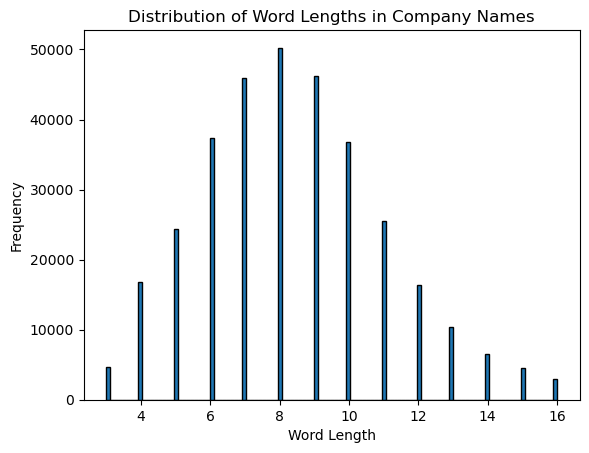

In [33]:
plt.hist(companies['name_length'], bins='auto', edgecolor='black')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title('Distribution of Word Lengths in Company Names')
plt.show()

In [31]:
companies.name_length.describe()

count    334858.000000
mean          8.563654
std           3.037653
min           1.000000
25%           7.000000
50%           8.000000
75%          10.000000
max          98.000000
Name: name_length, dtype: float64

In [32]:
companies = companies[companies.name.str.len() > 2] # delete names with length less than 3
companies = companies[companies.name.str.len() < 17] # and more than 16
companies.shape[0]

328661

In [49]:
companies.name_length.value_counts()

8     50174
9     46175
7     45839
6     37268
10    36739
11    25477
5     24271
4     16668
12    16407
13    10345
14     6531
3      4604
15     4499
16     2886
Name: name_length, dtype: int64

In [35]:
companies.isnull().sum()

country        0
name           0
size           0
name_length    0
dtype: int64

### Further cleaning

In [42]:
companies.drop_duplicates(subset="name", keep="first", inplace=True)
companies.shape[0]

327883

In [54]:
companies["size"].value_counts()

1-10          200402
11-50          85173
51-200         27007
201-500         7681
501-1000        3014
1001-5000       2850
10001+          1122
5001-10000       634
Name: size, dtype: int64

In [60]:
'1001-5000'.split()

['1001-5000']

In [64]:
companies["max_size"] = companies["size"].apply(lambda x: x.split('-')[1] if '-' in x else x[:-1])
companies.max_size = companies.max_size.astype('int')

In [68]:
companies[companies.max_size == 10]

,country,name,size,name_length,max_size
137,united kingdom,rockstarx,1-10,9,10
288,united states,investible,1-10,10,10
337,united states,flick,1-10,5,10
436,united kingdom,sparkwin,1-10,8,10
444,united kingdom,gplconstruction,1-10,15,10
...,...,...,...,...,...
13920158,united states,kcdc,1-10,4,10
13920172,united kingdom,foreverfutureuk,1-10,15,10
13920234,united states,goosetenants,1-10,12,10
13920256,united states,domophotos,1-10,10,10


In [75]:
companies.reset_index(inplace=True, drop=True)
companies.head(2)

,country,name,size,name_length,max_size
0,united states,equinoxys,51-200,9,200
1,united states,biassync,11-50,8,50


### Export the dataset

In [76]:
# export the cleaned dataset
companies.to_csv("../data/cleansed_layer/companies.csv", index=False)

In [41]:
df = pd.read_csv("../data/cleansed_layer/companies.csv")

In [42]:
df

,country,name,size,name_length,max_size
0,united states,equinoxys,51-200,9,200
1,united states,biassync,11-50,8,50
2,united kingdom,rockstarx,1-10,9,10
3,united states,taggpay,11-50,7,50
4,united states,touchpointe,11-50,11,50
...,...,...,...,...,...
327878,united kingdom,armory,11-50,6,50
327879,united states,goready,11-50,7,50
327880,canada,darpak,11-50,6,50
327881,united states,cannack,11-50,7,50


In [44]:
df.country.value_counts()

united states     224282
united kingdom     75431
canada             28170
Name: country, dtype: int64

In [45]:
usa = df[df.country == 'united states']

In [54]:
usa.to_csv("../data/cleansed_layer/companies_usa_size_over_10.csv")

In [47]:
usa

,country,name,size,name_length,max_size
0,united states,equinoxys,51-200,9,200
1,united states,biassync,11-50,8,50
3,united states,taggpay,11-50,7,50
4,united states,touchpointe,11-50,11,50
6,united states,investible,1-10,10,10
...,...,...,...,...,...
327875,united states,keener,11-50,6,50
327877,united states,oversightgroup,11-50,14,50
327879,united states,goready,11-50,7,50
327881,united states,cannack,11-50,7,50


In [49]:
usa.max_size.value_counts()

10       133209
50        59493
200       19873
500        5779
1000       2306
5000       2226
10001       907
10000       489
Name: max_size, dtype: int64

In [51]:
usa = usa[usa.max_size > 10]

In [55]:
usa.shape

(91073, 5)